


#### Abstract

<span style="color:red">This code includes Autoregressive RNN architecture. Which means the last state of the RNN will be fed into the prediction model. The RNN model will try to predict 1 hour in the future (horizon) by looking at the 24hour in the past of all the features shared in the dataset. Additionaly, "time" is used as a feature in this model as well and since it is periodic cos and sin components are taken into account.</span>


In order to reduce the size of your Moodle submission, please also do _not_ include the original datasets into your ZIP archive and do _not_ change file names of these datasets! Instead, set the relative path to the folder where these datasets are supposed to be located to the `DATA_PATH` variable in the code cell below (if the datasets should be located in the same folder with this main file, set `DATA_PATH` to `'./'`). If you want to modify the original datasets and save them for later use and if your code relies on reading these processed datasets from disk, consider saving/loading them with `pickle` module and include the PKL files into your Moodle submission.

In [3]:
DATA_PATH = './datasets/'

Hello!

This submission file will include demonstration part as well as automated training part for forecasting for the three power plants.

This code includes Autoregressive RNN architecture. Which means the last state of the RNN will be fed into the prediction model.

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

You will need to change the following parameters if you change the file names, number of predictions etc.

In [5]:

#PARAMETERS
data_train_1 = DATA_PATH+"data_train_1.csv"
data_train_2 = DATA_PATH+"data_train_2.csv"
data_train_3 = DATA_PATH+"data_train_3.csv"
data_test_1 = DATA_PATH+"data_test_1.csv"
data_test_2 = DATA_PATH+"data_test_2.csv"
data_test_3 = DATA_PATH+"data_test_3.csv"

train_datasets = [data_train_1,data_train_2,data_train_3 ]
test_datasets = [data_test_1,data_test_2,data_test_3 ]
label_list = ["power"]

WINDOW = 24 #Number of timestamps we want the model learn
HORIZON = 1 #Number of points in the future we want to predict

#CONSTRAINTS
NUMBER_OF_P_PLANTS = 3 #Number of PV plants (files)
PREDS_INTO_FUTURE = 2880 #Number of predicted points in the future, fixed number



In [6]:
raw_dataframe_train = pd.read_csv(data_train_1)
raw_dataframe_test = pd.read_csv(data_test_1)
len_test = len(raw_dataframe_test)
raw_dataframe_train

,datetime,tclw,tciw,sp,r,tcc,10u,10v,2t,ssrd,strd,tsr,tp,power
0,2012-05-01 00:00:00,0.000000,0.026691,95462.2500,74.200241,0.814880,0.523571,-1.758471,285.401856,11866936.0,25408576.0,14246758.0,0.000000,0.680962
1,2012-05-01 01:00:00,0.000000,0.010275,95448.8750,73.447479,0.972576,1.174747,-1.753343,286.291504,1804488.0,1087089.0,2044841.0,0.000000,0.749167
2,2012-05-01 02:00:00,0.000000,0.010820,95352.2500,63.944000,0.999995,1.577120,-1.907180,288.059082,3977192.0,2167960.0,4418795.0,0.000000,0.619295
3,2012-05-01 03:00:00,0.000000,0.032585,95274.9375,58.032181,0.998322,2.060949,-2.126363,289.278565,6150811.0,3253130.0,6814094.0,0.000000,0.638590
4,2012-05-01 04:00:00,0.000000,0.014685,95204.1250,55.889816,0.770172,2.074888,-2.336928,289.616455,7826656.0,4364538.0,8762575.0,0.000000,0.346987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,2013-12-31 19:00:00,0.011330,0.004052,94444.9375,79.418243,0.957397,-0.837689,0.501957,286.870117,25236960.0,22284352.0,27001424.0,0.000076,0.000577
14636,2013-12-31 20:00:00,0.008402,0.000164,94442.5000,80.466263,0.163549,-0.348717,0.563321,287.772217,25453008.0,23386400.0,27331296.0,0.000076,0.044936
14637,2013-12-31 21:00:00,0.002462,0.000082,94445.7500,77.510193,0.114380,-0.337349,-0.411636,289.293701,26407456.0,24542640.0,28505600.0,0.000080,0.159936
14638,2013-12-31 22:00:00,0.000488,0.003376,94448.2500,69.369843,0.360260,0.488571,-1.128106,291.502441,28210800.0,25674752.0,30542256.0,0.000080,0.289487


In [7]:
# LETS CHECK WHETHER IS THERE ANY NAN VALUES
raw_dataframe_train.isnull().values.any()

False

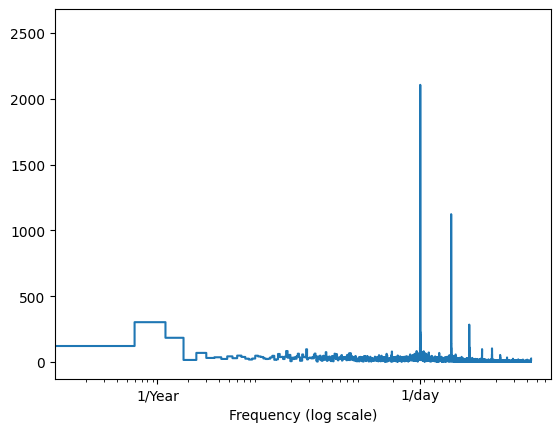

In [8]:
#This code is to determine which periods are important
fft = tf.signal.rfft(raw_dataframe_train['power'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(raw_dataframe_train['power'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
#plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

#AS WE CAN SEE, 1 DAY IS IMPORTANT

In [9]:
#Also, since the date time has a periodicity, we should convert it to a periodical signal
date = pd.to_datetime(raw_dataframe_train.pop("datetime"))
date = date.map(pd.Timestamp.timestamp)
day = 24*60*60
#year = (365.2425)*day
raw_dataframe_train['Day sin'] = np.sin(date * (2 * np.pi / day))
raw_dataframe_train['Day cos'] = np.cos(date * (2 * np.pi / day))
date = pd.to_datetime(raw_dataframe_test.pop("datetime"))
date = date.map(pd.Timestamp.timestamp)
day = 24*60*60
#year = (365.2425)*day
raw_dataframe_test['Day sin'] = np.sin(date * (2 * np.pi / day))
raw_dataframe_test['Day cos'] = np.cos(date * (2 * np.pi / day))


In [10]:
train_df = raw_dataframe_train[:int(0.8*len(raw_dataframe_train))]
validation_df = raw_dataframe_train[int(0.8*len(raw_dataframe_train)):int(len(raw_dataframe_train))]
test_df = raw_dataframe_test


The following code is to separate data into windows and horizons as follows:

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Since horizon = 1 and window = 7 as default,

[1, 2, 3, 4, 5, 6, 7] [8]
[2, 3, 4, 5, 6, 7, 8] [9]
[3, 4, 5, 6, 7, 8, 9] [10]


In [12]:

def separation_new(time_series, horizon = 1, window = 7,):
    my_list = time_series[:,:window]
    my_list_2 = time_series[:,window:window+horizon]
    return tf.cast(my_list, dtype=tf.float32), tf.cast(my_list_2, dtype=tf.float32)


def window_and_horizon_elegante_new(data_frame, horizon = 1, window = 7, the_label_column_name = []):
    result_dict = {}
    label = []
    column_names = list(data_frame.columns)
    a = np.expand_dims(np.arange(window+horizon), axis=0) 
    
    for column_name in column_names:
        if column_name in the_label_column_name:
            windowed_label = []
            windowed_horizon = []
            window_indexes = a + np.expand_dims(np.arange(len(data_frame[f"{column_name}"].to_numpy())-(window+horizon)+1), axis=0).T 
            windowed_label, windowed_horizon = separation_new(time_series = data_frame[f"{column_name}"].to_numpy()[window_indexes], horizon=horizon, window=window)
            result_dict[column_name] = tf.expand_dims(windowed_label, axis=-1)
            label.append(tf.expand_dims(windowed_horizon, axis=-1))
        else:
            windowed_label = []
            windowed_horizon = []
            window_indexes = a + np.expand_dims(np.arange(len(data_frame[f"{column_name}"].to_numpy())-(window+horizon)+1), axis=0).T 
            
            windowed_label, windowed_horizon = separation_new(time_series = data_frame[f"{column_name}"].to_numpy()[window_indexes], horizon=horizon, window=window)
            result_dict[column_name] = tf.expand_dims(windowed_label, axis=-1)
    
    label = np.concatenate(label, axis=-1)
    
    return result_dict, label


In [13]:
result, label = window_and_horizon_elegante_new(train_df ,horizon=HORIZON, window=WINDOW, the_label_column_name=["power"])
result, label

({'tclw': <tf.Tensor: shape=(11688, 24, 1), dtype=float32, numpy=
  array([[[0.0000000e+00],
          [0.0000000e+00],
          [0.0000000e+00],
          ...,
          [5.2185059e-03],
          [1.3442993e-02],
          [3.7094116e-02]],
  
         [[0.0000000e+00],
          [0.0000000e+00],
          [0.0000000e+00],
          ...,
          [1.3442993e-02],
          [3.7094116e-02],
          [6.1340332e-02]],
  
         [[0.0000000e+00],
          [0.0000000e+00],
          [0.0000000e+00],
          ...,
          [3.7094116e-02],
          [6.1340332e-02],
          [5.6228857e-02]],
  
         ...,
  
         [[2.6798199e-04],
          [2.3799999e-05],
          [4.1770900e-04],
          ...,
          [0.0000000e+00],
          [0.0000000e+00],
          [0.0000000e+00]],
  
         [[2.3799999e-05],
          [4.1770900e-04],
          [1.4534000e-03],
          ...,
          [0.0000000e+00],
          [0.0000000e+00],
          [0.0000000e+00]],
  
         [[4

In [15]:
#Train and validation splitting

result, label = window_and_horizon_elegante_new(train_df ,horizon=HORIZON, window=WINDOW, the_label_column_name=label_list)
train_data = tf.data.Dataset.from_tensor_slices((result, label))

result, label = window_and_horizon_elegante_new(validation_df ,horizon=HORIZON, window=WINDOW, the_label_column_name=label_list)
val_data = tf.data.Dataset.from_tensor_slices((result, label))

train_data = train_data.shuffle(len(train_df)*2).batch(256).prefetch(tf.data.AUTOTUNE)
val_data = val_data.batch(256).prefetch(tf.data.AUTOTUNE)

In [17]:
'''
    Create normalization layer for each column in the dataframe.
    Only the predicted column will be inverted at the end.
'''
def get_normalization_layer(name):
    if name in label_list:#Change this according to the label name
        layer = tf.keras.layers.Normalization(axis=None, invert=True)
    else:
        layer = tf.keras.layers.Normalization(axis=None, invert=False)
    layer.adapt(train_data.map(lambda x,y: x[name]))
    return layer

In [18]:
col_names = list(train_df.columns)
all_inputs = []
normalized_inputs = []
normalization_layers = []

for col_name in col_names:
    inputs = tf.keras.layers.Input(shape=(WINDOW,1), name=col_name)
    layer = get_normalization_layer(col_name, )
    normalization_layers.append(layer)
    all_inputs.append(inputs)
    normalized_inputs.append(layer(inputs))

In [19]:
#Autoregressive model
class MyModel(tf.keras.Model):
  def __init__(self, rnn_units, horizon):
    super().__init__(self)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                  return_sequences=False,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(64, activation="linear")
    self.dense_out = tf.keras.layers.Dense(len(label_list), activation="linear")

  def call(self, inputs, states=None, return_state=False, training=True):
    x = inputs
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense_out(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [20]:
x = tf.keras.layers.Concatenate(axis=-1)(normalized_inputs)
reg_model = MyModel(128, 1)
outputs = reg_model(inputs = x)
model = tf.keras.Model(inputs = all_inputs, outputs = outputs)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
                loss="mse",
                metrics=["mae", "mse"])

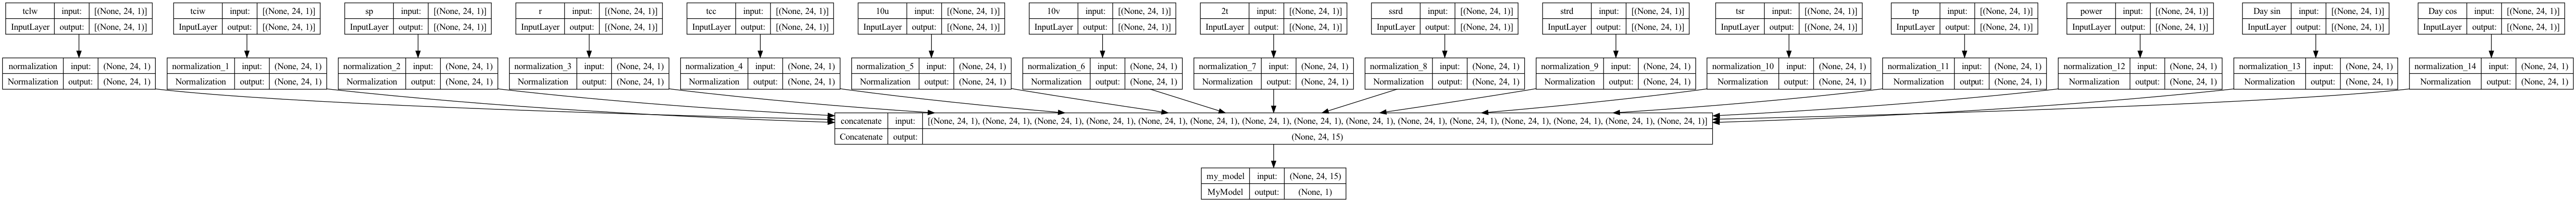

In [21]:
from keras.utils import plot_model
plot_model(model, show_shapes= True, to_file='model.png')

In [22]:
def create_model_check_point(filepath,model_name):
    return tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath+"/"+model_name,
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True)

In [23]:
model.fit(train_data,
            validation_data=val_data, 
            epochs=40, callbacks=[create_model_check_point("Checkpoints", "autoregressive_new"),
                                  tf.keras.callbacks.EarlyStopping(monitor="val_mae",patience=10, verbose=1, restore_best_weights=True)],
            validation_steps=len(val_data),
            steps_per_epoch=len(train_data), 
            batch_size=256)

Epoch 1/40
46/46 [==============================] - 3s 40ms/step - loss: 0.0272 - mae: 0.1147 - mse: 0.0272 - val_loss: 0.0106 - val_mae: 0.0705 - val_mse: 0.0106
Epoch 2/40
46/46 [==============================] - 2s 35ms/step - loss: 0.0087 - mae: 0.0628 - mse: 0.0087 - val_loss: 0.0081 - val_mae: 0.0591 - val_mse: 0.0081
Epoch 3/40
46/46 [==============================] - 2s 34ms/step - loss: 0.0076 - mae: 0.0570 - mse: 0.0076 - val_loss: 0.0077 - val_mae: 0.0578 - val_mse: 0.0077
Epoch 4/40
46/46 [==============================] - 2s 35ms/step - loss: 0.0070 - mae: 0.0539 - mse: 0.0070 - val_loss: 0.0070 - val_mae: 0.0532 - val_mse: 0.0070
Epoch 5/40
46/46 [==============================] - 2s 37ms/step - loss: 0.0068 - mae: 0.0531 - mse: 0.0068 - val_loss: 0.0066 - val_mae: 0.0507 - val_mse: 0.0066
Epoch 6/40
46/46 [==============================] - 2s 34ms/step - loss: 0.0065 - mae: 0.0507 - mse: 0.0065 - val_loss: 0.0066 - val_mae: 0.0495 - val_mse: 0.0066
Epoch 7/40
46/46 [====

In [24]:
model.load_weights("Checkpoints"+"/"+"autoregressive_new")

In [26]:
#Forecasting
'''
    This forecasting process is autoregressive, which means that model will learn by looking 'window' in the future and predict 'horizon'. 
    Then, the result will added at the end and 'window' and 'horizon' will be shifted.
    The important part is that the state of the RNN will be forwarded to the next prediction step so that the model will not forget what it predicted before.
'''
last_section_df = train_df[-WINDOW:]
window_df = pd.concat([last_section_df, validation_df], ignore_index=True)

j = 0
predictions = []
state = None
while j<len(validation_df):
    val_values = window_df["power"].values
    result = window_df[j:j+WINDOW].values
    for i, _ in enumerate(col_names):
        result[:,i] = normalization_layers[i](result[:,i])
    prediction, state = reg_model(inputs = tf.expand_dims(result, axis=0), states = state, return_state=True, training = False)
    prediction = tf.squeeze(prediction).numpy()
    if prediction < 0: #Note that PV plant outputs cannot be lower than 0.
        prediction = 0.0
    predictions.append(prediction)
    val_values[WINDOW+j] = prediction
    window_df["power"] = val_values
    j = j + 1  


In [27]:
predictions = np.array(predictions)
predictions

array([0.81083554, 0.80331028, 0.75810313, ..., 0.14282463, 0.33961532,
       0.54259872])

Now, we can proceed to the training for all power plants.

In [ ]:
results = np.zeros(shape=(PREDS_INTO_FUTURE, NUMBER_OF_P_PLANTS))

for i in range(NUMBER_OF_P_PLANTS):
    
    MODEL_NAME = f"auto_regressive_new_all{i}"
    
    raw_dataframe_train = pd.read_csv(train_datasets[i])
    raw_dataframe_test = pd.read_csv(test_datasets[i])
    raw_dataframe_test["power"] = np.zeros(len(raw_dataframe_test))
    
    #Also, since the date time has a periodicity, we should convert it to a periodical signal
    date = pd.to_datetime(raw_dataframe_train.pop("datetime"))
    date = date.map(pd.Timestamp.timestamp)
    day = 24*60*60
    raw_dataframe_train['Day sin'] = np.sin(date * (2 * np.pi / day))
    raw_dataframe_train['Day cos'] = np.cos(date * (2 * np.pi / day))
    
    date = pd.to_datetime(raw_dataframe_test.pop("datetime"))
    date = date.map(pd.Timestamp.timestamp)
    day = 24*60*60
    raw_dataframe_test['Day sin'] = np.sin(date * (2 * np.pi / day))
    raw_dataframe_test['Day cos'] = np.cos(date * (2 * np.pi / day))

    train_df = raw_dataframe_train[:int(1*len(raw_dataframe_train))]
    test_df = raw_dataframe_test

    label_list = ["power"]

    result, label = window_and_horizon_elegante_new(train_df ,horizon=HORIZON, window=WINDOW, the_label_column_name=label_list)
    train_data = tf.data.Dataset.from_tensor_slices((result, label))

    train_data = train_data.shuffle(len(train_df)*2).batch(256).prefetch(tf.data.AUTOTUNE)

    col_names = list(train_df.columns)
    all_inputs = []
    normalized_inputs = []
    normalization_layers = []

    for col_name in col_names:
        inputs = tf.keras.layers.Input(shape=(WINDOW,1), name=col_name)
        layer = get_normalization_layer(col_name, )
        all_inputs.append(inputs)
        normalization_layers.append(layer)
        normalized_inputs.append(layer(inputs))
    
    x = tf.keras.layers.Concatenate(axis=-1)(normalized_inputs)
    reg_model = MyModel(128, 1)
    outputs = reg_model(inputs = x)

    model = tf.keras.Model(inputs = all_inputs, outputs = outputs)

    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
                    loss="mae",
                    metrics=["mae", "mse"])

    print(f"NOW TRAINING STARTS FOR PLANT {i+1}")
    
    model.fit(train_data,
                epochs=50, 
                steps_per_epoch=len(train_data), 
                batch_size=256)
    
    print(f"NOW TRAINING HAS FINISHED FOR PLANT {i+1}")
    
    print(f"NOW FORECASTING STARTS FOR PLANT {i+1}")
    #Forecasting
    last_section_df = train_df[-WINDOW:]
    window_df = pd.concat([last_section_df, test_df], ignore_index=True)

    j = 0
    predictions = []
    state = None
    while j<len(test_df):
        val_values = window_df["power"].values
        result = window_df[j:j+WINDOW].values
        for m, _ in enumerate(col_names):
            result[:,m] = normalization_layers[m](result[:,m])
            
        prediction, state = reg_model(inputs = tf.expand_dims(result, axis=0), states = state, return_state=True)
        prediction = tf.squeeze(prediction).numpy()
        if prediction < 0:
            prediction = 0.0
        if prediction > 1:
            prediction = 1.0
        predictions.append(prediction)
        val_values[WINDOW+j] = prediction
        window_df["power"] = val_values
        j = j + 1  
        
    results[:,i] = np.array(predictions)

